In [1]:
# Basic data handling and scientific computing
import numpy as np
import pandas as pd
import scipy.io
import scipy.stats as stats
import h5py
import os
import glob
import re
import gzip
import math

# Machine learning and data analysis tools
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

# Statistical methods
from scipy.stats import zscore, pearsonr, spearmanr
from scipy.ndimage import gaussian_filter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interpn

# Tensor and decomposition
import tensorly as tl
from tensorly.decomposition import non_negative_parafac

# Other utilities
import pyBigWig
from scipy.io import savemat
import textwrap

# Suppress warnings if necessary
import warnings
warnings.filterwarnings('ignore')

# Custom or other specific imports
import hicstraw  # Assumed specific to your use case

/home/dwk681/.conda/envs/multiomics6/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-18 06:54:53.328239: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 06:54:53.330852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-18 06:54:53.390627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-18 06:54:53.392189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [2]:
#This block imports the 3omics data for 153 single cells of two cell types.

base_directory = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/'

def normalize_matrix_columns(A):
    """
    Normalize each column of the matrix so that each has a norm of one.
    
    Parameters:
    - A: a 2D NumPy array (matrix)
    
    Returns:
    - normalized_A: a matrix where each column of A has been divided by its L2 norm
    """
    # Calculate the L2 norm for each column
    column_norms = np.linalg.norm(A, axis=0)
    
    # Avoid division by zero
    if np.any(column_norms == 0):
        raise ValueError("One or more columns have zero norm. Cannot normalize those columns.")
    
    # Normalize each column by its norm
    normalized_A = A / column_norms
    
    return normalized_A

def calculate_matrix(file_path):
    # Initialize an empty list to store the data
    data = []

    # Read the compressed file using gzip
    with gzip.open(file_path, 'rt') as file:
        for line in file:
            # Split the line into fields
            fields = line.strip().split('\t')

            # Extract relevant entries for calculations
            numerator_indices = range(6, len(fields), 2)
            denominator_indices = range(7, len(fields), 2)

            row_data = []
            for num_idx, denom_idx in zip(numerator_indices, denominator_indices):
                numerator = float(fields[num_idx])
                denominator = float(fields[denom_idx])

                # Check if denominator is zero, set entry to 0, else perform the division
                row_data.append(0 if denominator == 0 else numerator / denominator)

            data.append(row_data)

    # Convert the list of lists into a NumPy array
    data_matrix = np.array(data)

    return data_matrix

file_path = base_directory + 'b37.autosome.1Mb_interval.add_value.methy.bed.gz'
methylation_matrix_1Mb = normalize_matrix_columns(calculate_matrix(file_path))
print(methylation_matrix_1Mb.shape)

# Define the path to the file
file_path = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/filtered_bam_list.txt'

# Initialize an empty list to store the prefixes
prefixes = []

try:
    # Open and read the file with a different encoding
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            # Strip the newline character and append to the prefixes list
            prefixes.append(line.strip())
except UnicodeDecodeError:
    print("Failed to decode file with ISO-8859-1. Trying another method.")

# Print the list of prefixes
print(len(prefixes))

(2897, 129)
129


In [3]:
random_seed = 5
np.random.seed(random_seed)  # Set the seed for reproducibility

reducer = umap.UMAP(n_neighbors=50, n_components=2, random_state=random_seed)  # 2D UMAP, set random state for reproducibility
umap_results_1Mb = reducer.fit_transform(methylation_matrix_1Mb.T)

# Applying Kmaens clustering
kmeans = KMeans(n_clusters=2, random_state=random_seed)
kmeans.fit(umap_results_1Mb)
cluster_labels_1Mb = kmeans.labels_



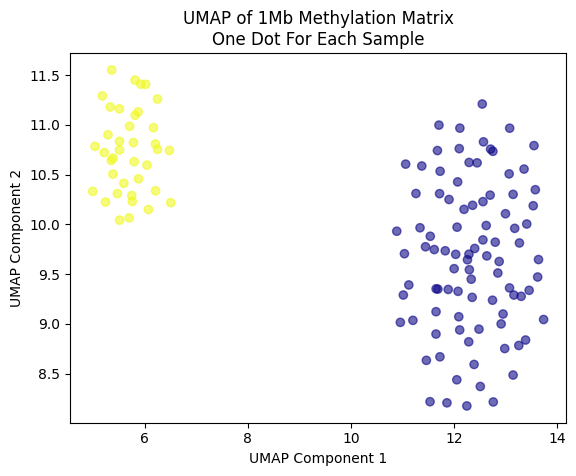

In [4]:
#view methylation UMPAPs
scatter = plt.scatter(umap_results_1Mb[:, 0], umap_results_1Mb[:, 1], alpha=0.6, c=cluster_labels_1Mb, cmap='plasma')
plt.title('UMAP of 1Mb Methylation Matrix\nOne Dot For Each Sample')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.show()

bam_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam'
methy_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam/methylation/filter_low_qual'
software_directory='../../bin/softwarefiles'
chrom_file='../../bin/softwarefiles/hg19.autosome.chrom.sizes'
fragments_file='../../bin/softwarefiles/hg19_DpnII.txt'
output_directory='../../projects/single_cell_files'
hg19_fa_url='ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz'
filtered_list='../../projects/single_cell_files/filtered_bam_list.txt'
schicluster_env='schicluster2'
bisulfite_env='bisulfitehic27'
min_high_quality_reads='250000'
resolutions='1000000:1Mb'
impute='True'
cluster_compartments='False'
cumulant='False'
iterations='900'
chromosomes=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
dark_regions_hg19_url='https://www.encodeproject.org/files/ENCFF000EHJ/@@download/ENCFF000EHJ.bigWig'
mappability_threshold='0.6'
data_type='o

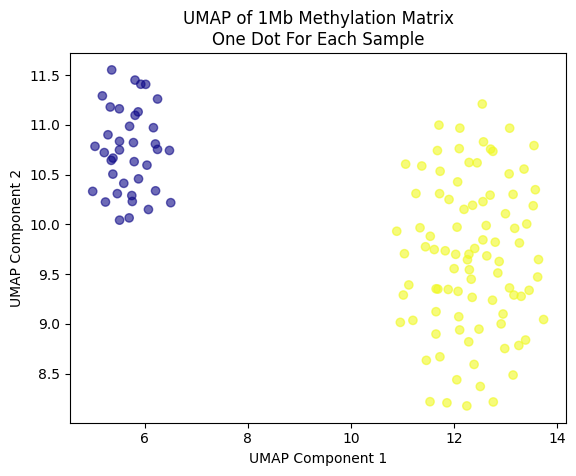

In [5]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from config_and_print import filtered_list, chrom_file, resolutions, normalization

output_directory = '../../projects/single_cell_files'

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

print(f"Resolutions from config: {resolutions}")
resolution_str = resolutions[0]
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, label = parse_resolution(resolution_str)

import h5py
import matplotlib.pyplot as plt
import numpy as np



prefix_file_path = '../../projects/single_cell_files/filtered_bam_list.txt'
# Read prefixes from the file
with open(prefix_file_path, 'r') as f:
    prefixes = [line.strip() for line in f] 

file_list = prefixes

chromosomes_info = {
    '1': 249250621,
    '2': 243199373,
    '3': 198022430,
    '4': 191154276,
    '5': 180915260,
    '6': 171115067,
    '7': 159138663,
    '8': 146364022,
    '9': 141213431,
    '10': 135534747,
    '11': 135006516,
    '12': 133851895,
    '13': 115169878,
    '14': 107349540,
    '15': 102531392,
    '16': 90354753,
    '17': 81195210,
    '18': 78077248,
    '19': 59128983,
    '20': 63025520,
    '21': 48129895,
    '22': 51304566,
}

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}



#view methylation UMPAPs
scatter = plt.scatter(umap_results_1Mb[:, 0], umap_results_1Mb[:, 1], alpha=0.6, c=color_vector, cmap='plasma')
plt.title('UMAP of 1Mb Methylation Matrix\nOne Dot For Each Sample')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.show()

Shape of W: (2897, 2)
Shape of H: (2, 129)


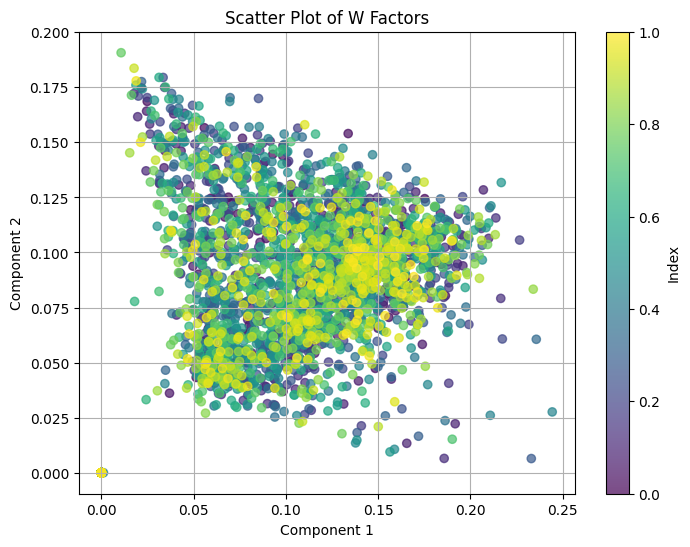

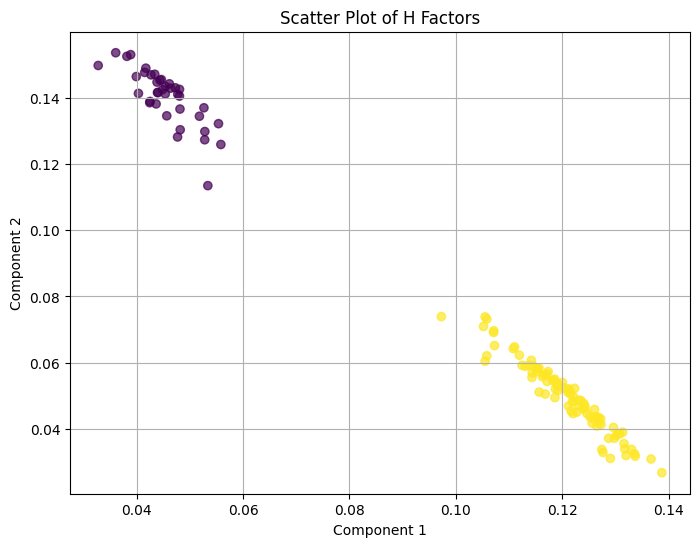

In [23]:
#make tensor of 2D directory
import h5py
import numpy as np
import os
from scipy.sparse import csr_matrix, identity
from sklearn.decomposition import NMF
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory
from scipy.ndimage import binary_dilation
from scipy.sparse import csr_matrix

# Given chromosome lengths and resolution
chromosome_lengths = {
    '1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260,
    '6': 171115067, '7': 159138663, '8': 146364022, '9': 141213431, '10': 135534747,
    '11': 135006516, '12': 133851895, '13': 115169878, '14': 107349540, '15': 102531392,
    '16': 90354753, '17': 81195210, '18': 78077248, '19': 59128983, '20': 63025520,
    '21': 48129895, '22': 51304566
}
resolution = 1000000

data_matrix = methylation_matrix_1Mb  

# Calculate bins per chromosome and slice data accordingly
chromosome_bins = {key: length // resolution for key, length in chromosome_lengths.items()}
chromosome_data = {}
start_bin = 0

for chromosome, bins in chromosome_bins.items():
    end_bin = start_bin + bins
    chromosome_data[chromosome] = data_matrix[start_bin:end_bin, :]
    start_bin = end_bin

def normalize_matrix_columns(A):
    column_norms = np.linalg.norm(A, axis=0)
    zero_norms = column_norms == 0
    column_norms[zero_norms] = 1
    normalized_A = A / column_norms
    normalized_A[:, zero_norms] = 0
    return normalized_A    
    
def load_csr_matrix_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        data = file['Matrix/data'][:]
        indices = file['Matrix/indices'][:]
        indptr = file['Matrix/indptr'][:]
        shape = file['Matrix'].attrs['shape']
    return csr_matrix((data, indices, indptr), shape=shape)

def normalize_matrix(A):
    norm = np.linalg.norm(A)
    if norm == 0:
        return A
    return A / norm

def nmf(matrix, rank):
    model = NMF(n_components=rank, init='random', random_state=0)
    W = model.fit_transform(matrix)
    H = model.components_
    reconstructed_matrix = np.dot(W, H)
    return reconstructed_matrix

def enforce_neighborhood_zeroing(methy_matrix, hic_matrix, neighborhood_size=4):
    # Create a boolean mask where hic_matrix is non-zero
    non_zero_mask = (hic_matrix != 0)
    
    # Dilate the non_zero_mask to include the neighborhood of the non-zero values
    dilated_non_zero_mask = binary_dilation(non_zero_mask, structure=np.ones((neighborhood_size*2 + 1, neighborhood_size*2 + 1)))
    
    # Set values in methy_matrix to zero wherever the dilated_non_zero_mask is False
    methy_matrix[~dilated_non_zero_mask] = 0
    
    return methy_matrix

def csr_pearson_correlation(csr_mat):
    """Calculates Pearson correlation from a CSR matrix."""
    csc_mat = csr_mat.tocsc()
    mean = np.array(csc_mat.mean(axis=1)).flatten()
    std_dev = np.sqrt(csc_mat.power(2).mean(axis=1).A1 - mean**2)
    valid_std_dev = std_dev != 0
    rows, cols = csr_mat.nonzero()
    standardized_data = np.divide(csr_mat.data - mean[rows], std_dev[rows], where=valid_std_dev[rows])
    standardized_csr = csr_matrix((standardized_data, (rows, cols)), shape=csr_mat.shape)
    correlation_matrix = standardized_csr.dot(standardized_csr.T).toarray()
    diag = np.sqrt(np.diag(correlation_matrix))

    # Adjusting diagonal for valid standard deviations
    diag = np.where(valid_std_dev, diag, 1)  # replace zero with one to avoid division by zero
    correlation_matrix /= diag[:, None]
    correlation_matrix /= diag[None, :]
    return csr_matrix(np.nan_to_num(correlation_matrix))  # Replace NaNs with zero, caused by division by zero


def make_matrix_non_negative(matrix):
    # Convert the sparse matrix to a dense format if it's not already
    if isinstance(matrix, csr_matrix):
        matrix = matrix.toarray()
    
    # Find the minimum value in the matrix
    min_value = np.min(matrix)
    
    # Calculate the value needed to add to make all elements non-negative
    if min_value < 0:
        offset = -min_value
    else:
        offset = 0
    
    # Add the offset to every element in the matrix
    new_matrix = matrix + offset
    
    return csr_matrix(new_matrix)  # Return as a sparse matrix if needed

def ensure_same_size(matrix1, matrix2, chrom, chromosome_lengths, resolution):
    """
    Ensure both matrices are the same size by padding with zeros as necessary.
    
    Parameters:
    - matrix1: First input matrix (can be sparse or dense).
    - matrix2: Second input matrix (can be sparse or dense).
    - chrom: Chromosome identifier (string).
    - chromosome_lengths: Dictionary mapping chromosome identifiers to their lengths.
    - resolution: Resolution value used to calculate the target matrix size.
    
    Returns:
    - matrix1: Padded version of matrix1.
    - matrix2: Padded version of matrix2.
    """
    # Convert CSR matrices to dense if they aren't already
    if isinstance(matrix1, csr_matrix):
        matrix1 = matrix1.toarray()
    if isinstance(matrix2, csr_matrix):
        matrix2 = matrix2.toarray()

    # Calculate the target size based on chromosome length and resolution
    chrom_length = chromosome_lengths.get(chrom, 0)
    target_size = math.ceil(chrom_length / resolution)

    # Function to pad a matrix to the new shape
    def pad_matrix(matrix, target_shape):
        padded_matrix = np.zeros(target_shape)
        padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
        return padded_matrix

    # Pad both matrices to the target size
    matrix1 = pad_matrix(matrix1, (target_size, target_size))
    matrix2 = pad_matrix(matrix2, (target_size, target_size))

    return matrix1, matrix2

# File to save all tensors
hdf5_filename = os.path.join('/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/', "all_cells_hic_methylation_tensors_correlation.h5")
with h5py.File(hdf5_filename, 'w') as all_chromosomes_file:
    # Loop through each chromosome and process its data
    for chromosome, data in chromosome_data.items():
        num_samples = data.shape[1]  # Number of samples
        outer_product_matrices = []
        hic_matrices = []
        
        chrom_string = f"chr{chromosome}"
        
        # Compute the outer product for each sample
        for sample_index in range(num_samples):
            prefix = prefixes[sample_index]
            vector = data[:, sample_index]
            outer_product_matrix = np.outer(vector, vector)
            
            hic_path = f'/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/hic_{label}_imputed_emphasized_dir/{chrom_string}/{prefix}_{chrom_string}.h5'
            
            if os.path.exists(hic_path):
                hic_matrix = load_csr_matrix_from_hdf5(hic_path)
                hic_matrix_dense = hic_matrix.toarray()
                #print(f"Loaded Hi-C matrix for {prefix} {chrom_string} with shape: {hic_matrix_dense.shape}")
            else:
                # Log the issue and create an identity matrix
                print(f"Hi-C matrix file not found for {prefix} {chrom_string}. Replacing with identity matrix.")
                target_size = math.ceil(chromosome_lengths[chromosome] / resolution)
                hic_matrix_dense = np.eye(target_size)
            
            # Ensure both matrices are the same size before setting elements to zero
            methy_matrix, hic_matrix = ensure_same_size(outer_product_matrix, hic_matrix_dense, chromosome, chromosome_lengths, resolution)
            
            hic_matrix = hic_matrix[:-1, :-1]
            methy_matrix = methy_matrix[:-1, :-1]
          
            hic_csr_matrix = csr_matrix(hic_matrix)
            hic_matrix = csr_pearson_correlation(make_matrix_non_negative(hic_csr_matrix))
            hic_matrix = hic_matrix.toarray()
            
            methy_matrix_sparse = enforce_neighborhood_zeroing(methy_matrix, hic_matrix, neighborhood_size=10)
            #hic_matrix = nmf(hic_matrix, 10)

            methy_matrix = normalize_matrix(methy_matrix_sparse) 
            hic_matrix = normalize_matrix(hic_matrix) 
            
            outer_product_matrices.append(methy_matrix)
            hic_matrices.append(hic_matrix)
        
        # Stack all the matrices into a tensor
        tensor_methy = np.stack(outer_product_matrices, axis=0)
        tensor_hic = np.stack(hic_matrices, axis=0)
        
        # Transpose the tensor to put the sample index as the third dimension
        tensor_methy_transposed = tensor_methy.transpose((1, 2, 0))
        tensor_hic_transposed = tensor_hic.transpose((1, 2, 0))
        
        # Combine methylation and Hi-C tensors into a 4D tensor
        combined_tensor = np.stack([tensor_methy_transposed, tensor_hic_transposed], axis=3)
        
        # Save the combined tensor to the collective HDF5 file
        all_chromosomes_file.create_dataset(f"chromosome_{chromosome}", data=combined_tensor, compression="gzip")

        # Also save individual tensors to separate HDF5 files for this chromosome
        individual_methy_filename = os.path.join(output_directory, f"chromosome_{chromosome}_tensor_methylation_correlation.h5")
        with h5py.File(individual_methy_filename, 'w') as individual_chromosome_file:
            individual_chromosome_file.create_dataset(f"chromosome_{chromosome}", data=tensor_methy_transposed, compression="gzip")

        individual_hic_filename = os.path.join(output_directory, f"chromosome_{chromosome}_tensor_hic_correlation.h5")
        with h5py.File(individual_hic_filename, 'w') as individual_chromosome_file:
            individual_chromosome_file.create_dataset(f"chromosome_{chromosome}", data=tensor_hic_transposed, compression="gzip")    
            
        print(f"Saved combined tensor for chromosome {chromosome} in the collective HDF5 file and individual tensors in separate files.")


Saved combined tensor for chromosome 1 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 2 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 3 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 4 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 5 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 6 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 7 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 8 in the collective HDF5 file and individual tensors in separate files.
Saved combined tensor for chromosome 9 in the collective HDF5 file and individual tensors in separate files.
Saved combined tens

In [24]:
hdf5_filename = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/chromosome_10_tensor_methylation_correlation.h5'

# To open and check a tensor for a specific chromosome (e.g., chromosome '1'):
with h5py.File(hdf5_filename, 'r') as hdf5_file:
    chromosome_10_tensor = hdf5_file['chromosome_10'][()]  # Load the tensor data into memory
    print("Shape of chromosome 10 tensor:", chromosome_10_tensor.shape)


Shape of chromosome 10 tensor: (135, 135, 129)


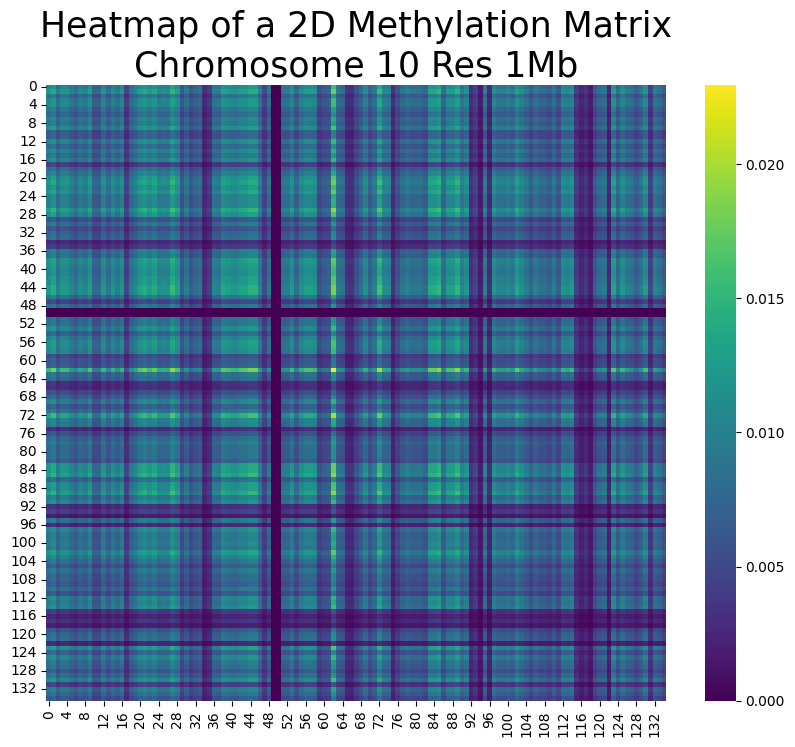

In [25]:
matrix = chromosome_10_tensor[:, :, 3]
import seaborn as sns

plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
ax = sns.heatmap(matrix, cmap='viridis')  # 'viridis' is a visually appealing colormap
plt.title('Heatmap of a 2D Methylation Matrix\nChromosome 10 Res 1Mb', fontsize=25)
plt.show()

In [26]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import matplotlib.pyplot as plt

# Perform Non-negative Tensor Factorization (rank-2)
rank = 2
weights, factors = non_negative_parafac(chromosome_10_tensor, rank=rank, init='random', random_state=0)

# Extracting the factor matrices
factor_1 = factors[0]
factor_2 = factors[1]
factor_3 = factors[2]


In [27]:
factor_3.shape

(129, 2)

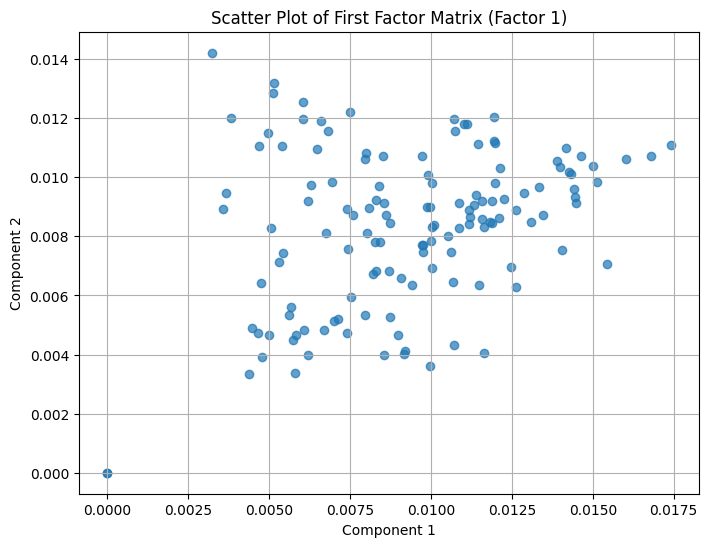

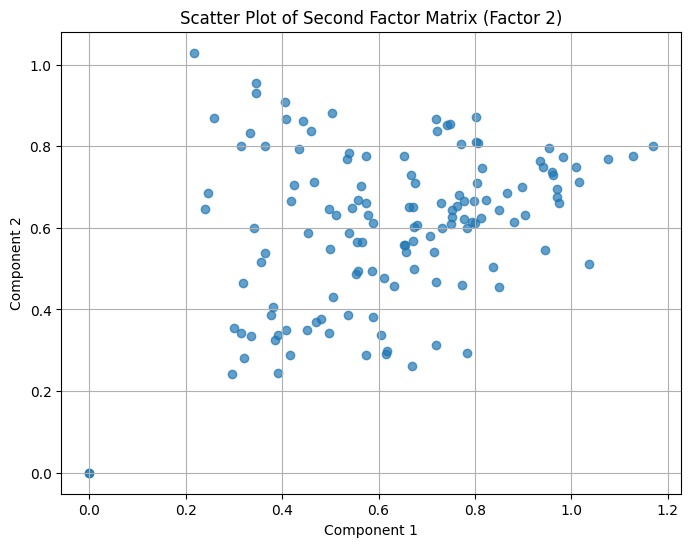

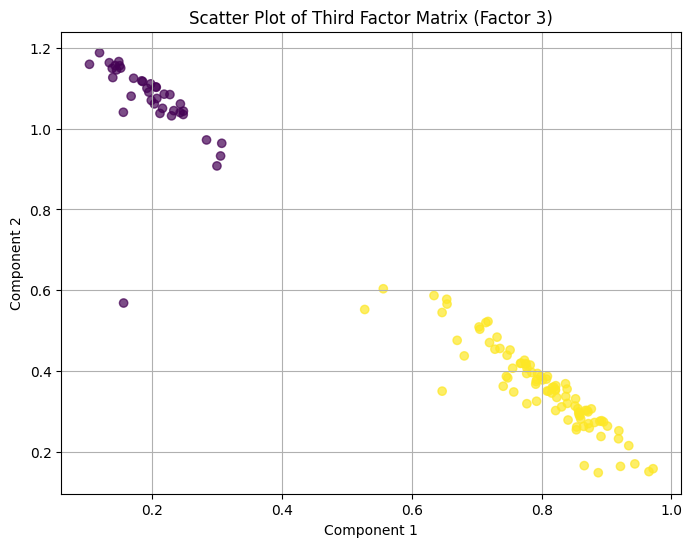

In [28]:
# Scatter plot for the first factor matrix (factor_1)
plt.figure(figsize=(8, 6))
plt.scatter(factor_1[:, 0], factor_1[:, 1], alpha=0.7)
plt.title('Scatter Plot of First Factor Matrix (Factor 1)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Scatter plot for the second factor matrix (factor_2)
plt.figure(figsize=(8, 6))
plt.scatter(factor_2[:, 0], factor_2[:, 1], alpha=0.7)
plt.title('Scatter Plot of Second Factor Matrix (Factor 2)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Scatter plot for the third factor matrix (factor_3)
plt.figure(figsize=(8, 6))
plt.scatter(factor_3[:, 0], factor_3[:, 1], c = color_vector, alpha=0.7)
plt.title('Scatter Plot of Third Factor Matrix (Factor 3)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


Shape of chromosome 10 tensor: (135, 135, 129)


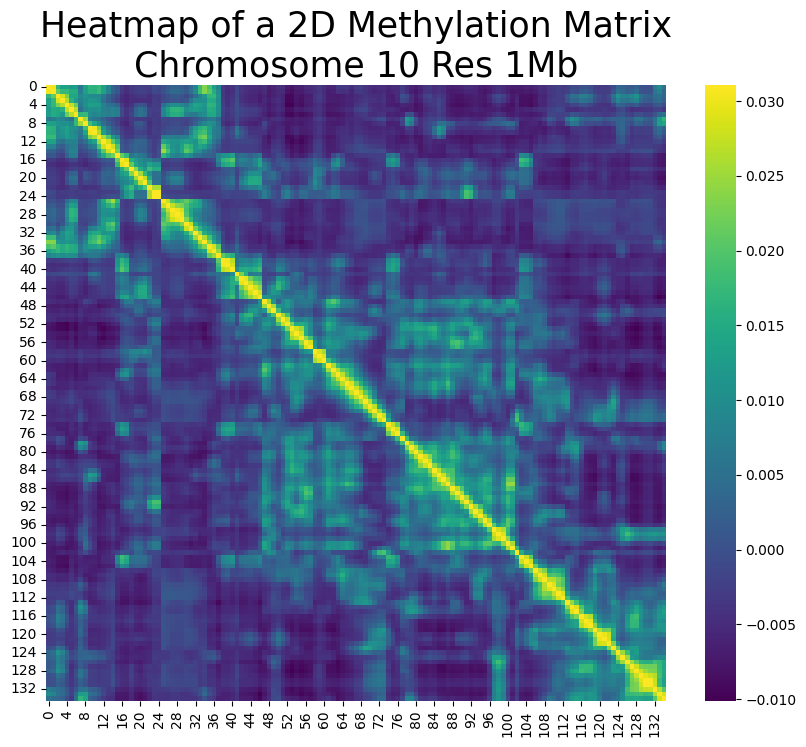

In [29]:
hdf5_filename = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/chromosome_10_tensor_hic_correlation.h5'

# To open and check a tensor for a specific chromosome (e.g., chromosome '1'):
with h5py.File(hdf5_filename, 'r') as hdf5_file:
    chromosome_10_tensor = hdf5_file['chromosome_10'][()]  # Load the tensor data into memory
    print("Shape of chromosome 10 tensor:", chromosome_10_tensor.shape)

matrix = chromosome_10_tensor[:, :, 30]
import seaborn as sns

plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
ax = sns.heatmap(matrix, cmap='viridis')  # 'viridis' is a visually appealing colormap
plt.title('Heatmap of a 2D Methylation Matrix\nChromosome 10 Res 1Mb', fontsize=25)
plt.show()

In [30]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import matplotlib.pyplot as plt

# Perform Non-negative Tensor Factorization (rank-2)
rank = 2
weights, factors = non_negative_parafac(chromosome_10_tensor, rank=rank, init='random', random_state=0)

# Extracting the factor matrices
factor_1 = factors[0]
factor_2 = factors[1]
factor_3 = factors[2]

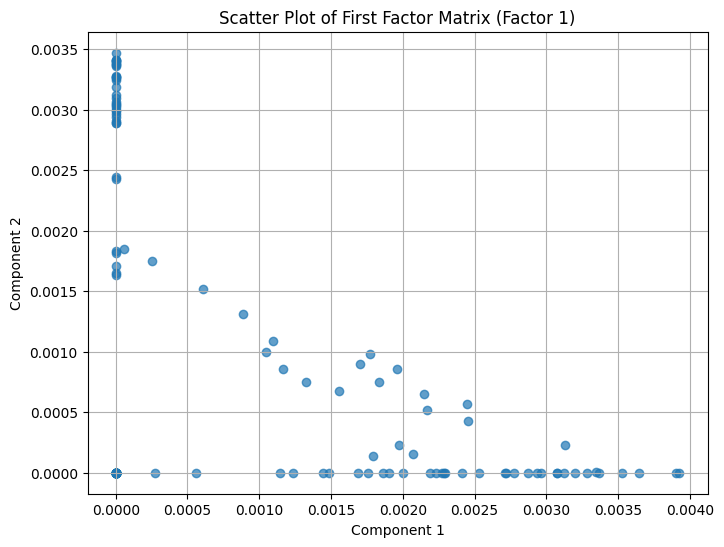

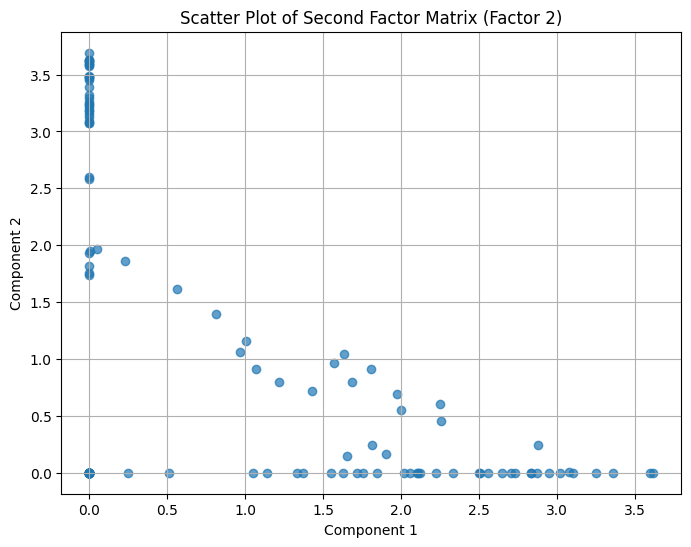

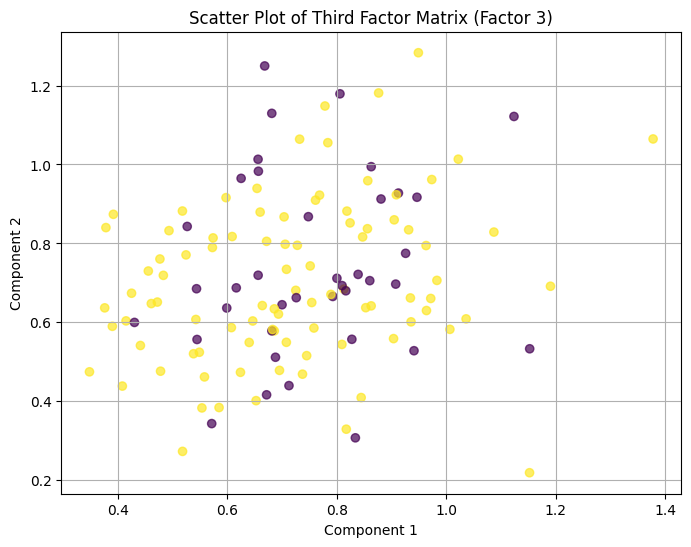

In [31]:
# Scatter plot for the first factor matrix (factor_1)
plt.figure(figsize=(8, 6))
plt.scatter(factor_1[:, 0], factor_1[:, 1], alpha=0.7)
plt.title('Scatter Plot of First Factor Matrix (Factor 1)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Scatter plot for the second factor matrix (factor_2)
plt.figure(figsize=(8, 6))
plt.scatter(factor_2[:, 0], factor_2[:, 1], alpha=0.7)
plt.title('Scatter Plot of Second Factor Matrix (Factor 2)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# Scatter plot for the third factor matrix (factor_3)
plt.figure(figsize=(8, 6))
plt.scatter(factor_3[:, 0], factor_3[:, 1], c = color_vector, alpha=0.7)
plt.title('Scatter Plot of Third Factor Matrix (Factor 3)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


In [ ]:
# Define the path to the directory containing HDF5 files for all chromosomes
hdf5_directory = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/'

# Define the list of chromosome numbers as strings
chromosomes = [str(i) for i in range(1, 23)]

# Initialize an empty list to store the factor_3 matrices
factor_3_matrices = []

# Define the rank for NTF
rank = 50

# Loop through each chromosome, perform NTF, and extract the third factor matrix
for chrom in chromosomes:
    hdf5_filename = os.path.join(hdf5_directory, f'chromosome_{chrom}_tensor_hic_correlation.h5')
    
    with h5py.File(hdf5_filename, 'r') as hdf5_file:
        chromosome_tensor = hdf5_file[f'chromosome_{chrom}'][()]  # Load the tensor data into memory
        print(f"Shape of chromosome {chrom} tensor:", chromosome_tensor.shape)
        
        # Perform Non-negative Tensor Factorization (rank-10)
        weights, factors = non_negative_parafac(chromosome_tensor, rank=rank, init='random', random_state=0)
        factor_3 = factors[2]  # Extract the third factor matrix (corresponding to the samples)
        
        # Append the extracted factor matrix to the list
        factor_3_matrices.append(factor_3)

# Concatenate all the factor_3 matrices into a single matrix
combined_factor_3_matrix = np.concatenate(factor_3_matrices, axis=1)

# Output the shape of the combined matrix
print("Shape of the combined factor_3 matrix:", combined_factor_3_matrix.shape)


Shape of chromosome 1 tensor: (249, 249, 129)
Shape of chromosome 2 tensor: (243, 243, 129)
Shape of chromosome 3 tensor: (198, 198, 129)


In [18]:
combined_factor_3_matrix.shape

(129, 1100)

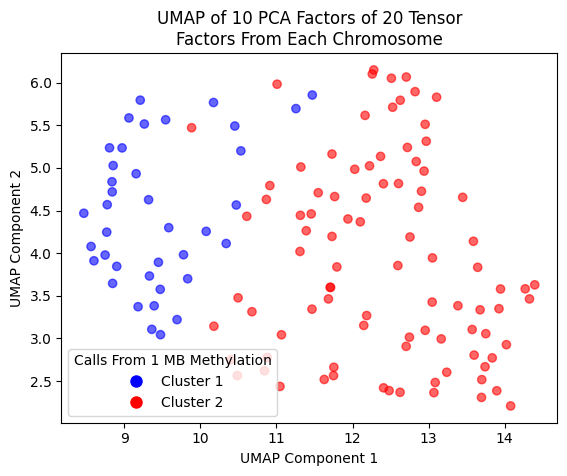

In [22]:
# Calculate the L2 norm of each column
col_norms = np.linalg.norm(combined_factor_3_matrix, axis=0)
# Avoid division by zero in case any column is zero
col_norms[col_norms == 0] = 1
matrix = combined_factor_3_matrix / col_norms

pca = PCA(n_components=3)
pca_results = pca.fit_transform(matrix)

reducer = umap.UMAP(n_neighbors=50, n_components=2, random_state=42)  # 2D UMAP, set random state for reproducibility
umap_tensor = reducer.fit_transform(pca_results)

# Assuming 'umap_results' and 'color_vector' are defined
# Define colors explicitly for the categories
colors = ['blue' if x == 0 else 'red' for x in color_vector]

# Scatter plot
scatter = plt.scatter(umap_tensor[:, 0], umap_tensor[:, 1], alpha=0.6, c=colors)
plt.title('UMAP of 10 PCA Factors of 20 Tensor\nFactors From Each Chromosome')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 2')]
plt.legend(handles=legend_elements, title='Calls From 1 MB Methylation')

plt.show()

In [16]:
combined_factor_3_matrix.shape
np.save('combined_factor_3_matrix_50ranksforeachchromosome_seperation_imputation.npy', combined_factor_3_matrix)